In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

2022-09-20 20:00:42.192378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 20:00:42.302319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 20:00:42.303260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 20:00:42.305176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510], dtype=int32)>

In [2]:
# Opening the dataframe and setting the index
Univariate_data = pd.read_csv('../input/univariate-labeled/Univariate_Labeled_DEF_4.csv', parse_dates=['DateTime'])
Univariate_data['DayOfWeek'] = Univariate_data['DateTime'].dt.day_of_week # Introducing the day of the week
Univariate_data.drop(columns='DateTime', inplace=True) # Removing DateTime (we have the day of the week)
Univariate_data = Univariate_data[0:34944] # 52 weeks
Univariate_data

,Consumption,Anomaly,DayOfWeek
0,950.0,0,2
1,939.0,0,2
2,943.0,0,2
3,971.0,0,2
4,1014.0,0,2
...,...,...,...
34939,886.0,0,1
34940,883.0,0,1
34941,868.0,0,1
34942,872.0,0,1


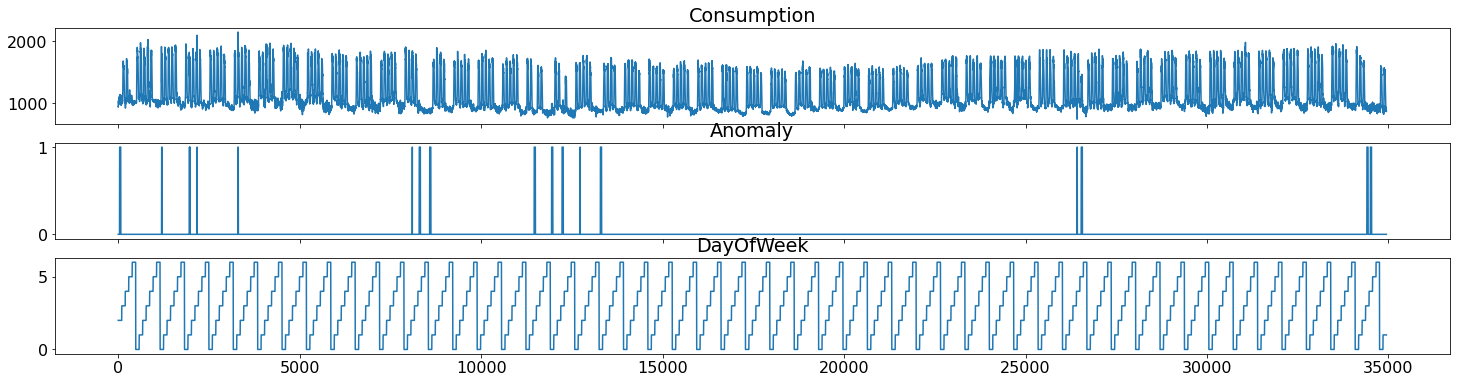

In [3]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [4]:
# Columns used for the following split in train, test and validation sets
Univariate_data['Test'] = 0
Univariate_data['Validation'] = 0
Univariate_data['Train_P1'] = 0
Univariate_data['Train_P2'] = 0
Univariate_data['Train_P3'] = 0
Univariate_data

,Consumption,Anomaly,DayOfWeek,Test,Validation,Train_P1,Train_P2,Train_P3
0,950.0,0,2,0,0,0,0,0
1,939.0,0,2,0,0,0,0,0
2,943.0,0,2,0,0,0,0,0
3,971.0,0,2,0,0,0,0,0
4,1014.0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34939,886.0,0,1,0,0,0,0,0
34940,883.0,0,1,0,0,0,0,0
34941,868.0,0,1,0,0,0,0,0
34942,872.0,0,1,0,0,0,0,0


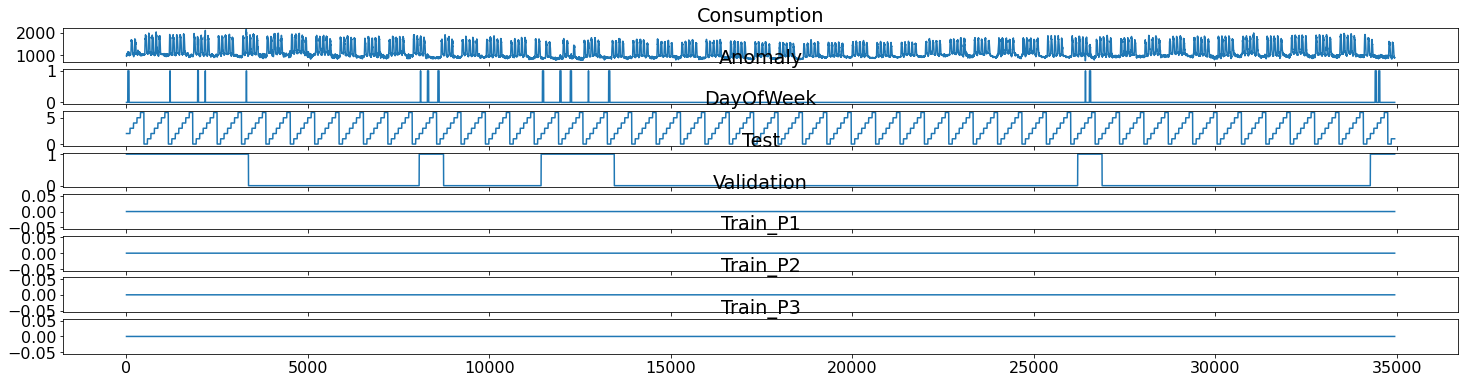

In [5]:
# TEST SET

# Weeks containing anomalies
for i in range (52):
    Slice_Univariate_data = Univariate_data.iloc[(i)*672:(i+1)*672]
    if(Slice_Univariate_data['Anomaly'].sum() != 0):
        for k in range (i*672, (i+1)*672):
            Univariate_data.at[k, 'Test'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

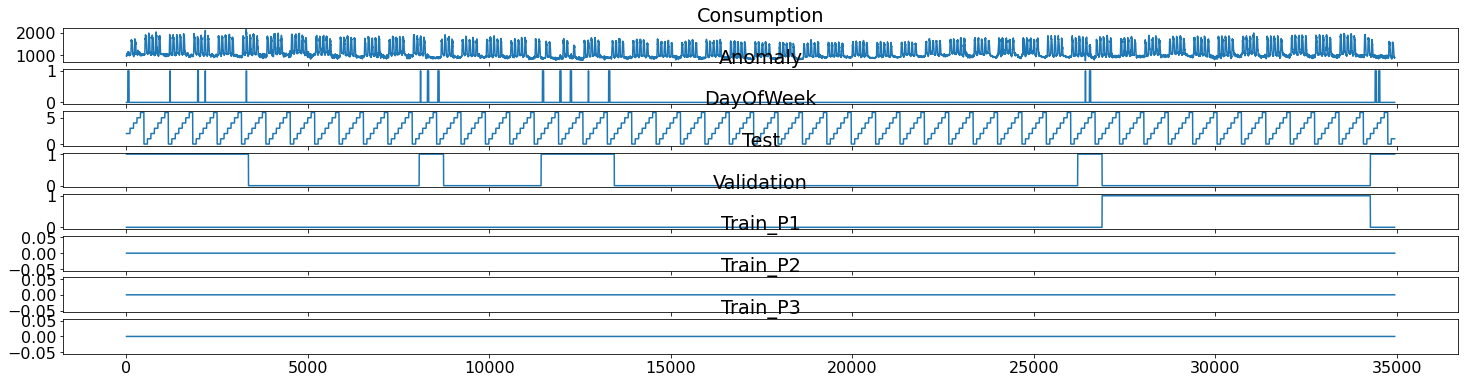

In [6]:
# VALIDATION SET

# Some random weeks
week = [40,41,42,43,44,45,46,47,48,49,50]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Validation'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [7]:
# TRAINING SET

week = [5,6,7,8,9,10,11]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P1'] = 1
    
week = [13,14,15,16]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P2'] = 1
    
week = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P3'] = 1

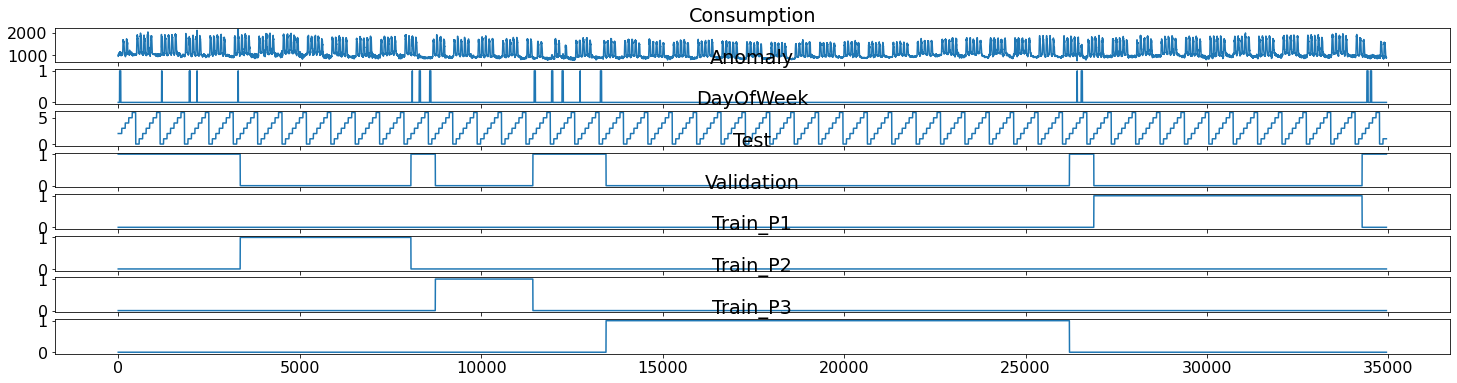

In [8]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [9]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = Univariate_data[Univariate_data['Train_P1']==1].copy()
X_train_temp_P2 = Univariate_data[Univariate_data['Train_P2']==1].copy()
X_train_temp_P3 = Univariate_data[Univariate_data['Train_P3']==1].copy()
X_validation_temp = Univariate_data[Univariate_data['Validation']==1].copy()
X_test_temp = Univariate_data[Univariate_data['Test']==1].copy()

In [10]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly']]
Anomaly_Train_P3 = X_train_temp_P3[['Anomaly']]
Anomaly_Validation = X_validation_temp[['Anomaly']]
Anomaly_Test = X_test_temp[['Anomaly']]

In [11]:
temp = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global = pd.concat([X_train_temp_P3,temp],axis=0)
X_train_temp_global.shape

(20160, 8)

In [12]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_train_raw_P3 = (X_train_temp_P3-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0]+X_train_raw_P3.shape[0] == Univariate_data.shape[0])

Consumption    1136.788542
Anomaly           0.000000
DayOfWeek         3.000000
Test              0.000000
Validation        0.000000
Train_P1          0.233333
Train_P2          0.133333
Train_P3          0.633333
dtype: float64 Consumption    282.830237
Anomaly          0.000000
DayOfWeek        2.000050
Test             0.000000
Validation       0.000000
Train_P1         0.422963
Train_P2         0.339943
Train_P3         0.481906
dtype: float64
True


In [13]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['Consumption', 'DayOfWeek']]
X_train_raw_P2 = X_train_raw_P2[['Consumption', 'DayOfWeek']]
X_train_raw_P3 = X_train_raw_P3[['Consumption', 'DayOfWeek']]
X_validation_raw = X_validation_raw[['Consumption', 'DayOfWeek']]
X_test_raw = X_test_raw[['Consumption', 'DayOfWeek']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_train_raw_P3.shape, X_validation_raw.shape, X_test_raw.shape

((4704, 2), (2688, 2), (12768, 2), (7392, 2), (7392, 2))

In [14]:
X_train_raw_P1.reset_index(inplace=True)
X_train_raw_P1.drop(columns='index', inplace=True)
X_train_raw_P2.reset_index(inplace=True)
X_train_raw_P2.drop(columns='index', inplace=True)
X_train_raw_P3.reset_index(inplace=True)
X_train_raw_P3.drop(columns='index', inplace=True)
X_validation_raw.reset_index(inplace=True)
X_validation_raw.drop(columns='index', inplace=True)
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)

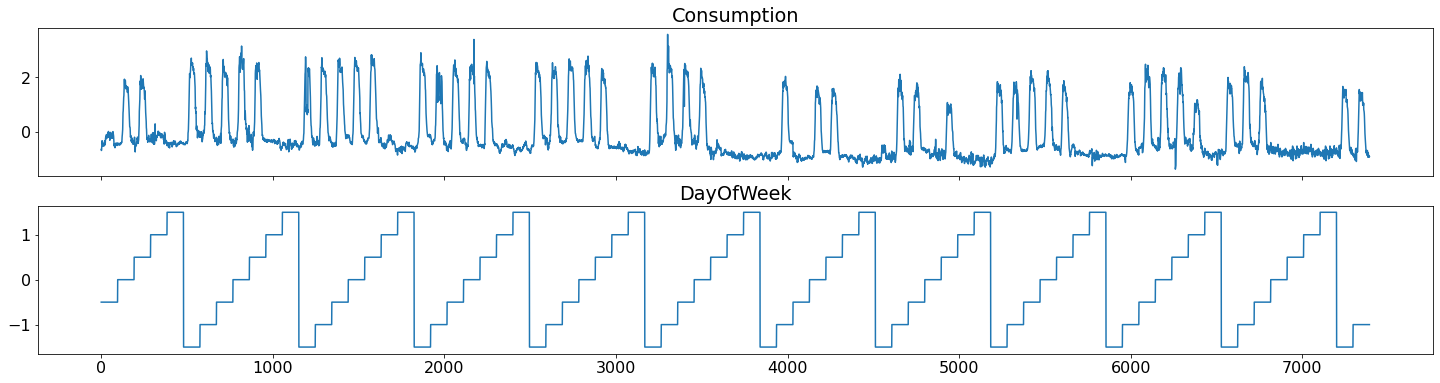

In [15]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training - Preparation

In [16]:
# Training parameters

window = 672       # 1 week
stride = 4         # 1 hour
latent_dim = 10    # Latent dimension - lat_dim = 16 is better !!!
epochs = 500       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
M = 200            # Montecarlo
alpha = 0.5
noise_factor = [0.1, 0.1]

In [17]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [18]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_train_P3, A_train_P3 = build_sequences(X_train_raw_P3, Anomaly_Train_P3, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape,X_train_P3.shape

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1009, 672, 2), (505, 672, 2), (3025, 672, 2))

In [19]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
X_train = np.concatenate([X_train,X_train_P3],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
A_train = np.concatenate([A_train,A_train_P3],axis=0)
X_train.shape, A_train.shape

((4539, 672, 2), (4539, 672, 1))

In [20]:
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=window) 
X_test.shape

PADDING: 0


(11, 672, 2)

## Building the model + Training

In [21]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [22]:
# Reparametrization trick
def sample_z1(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

# Reparametrization trick
def sample_z2(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [23]:
class AddNoise(tfk.layers.Layer):
    
    def call(self, inputs):
        data, noise_factor = inputs
        noise = tf.map_fn(fn=lambda t: tf.random.normal((672,2), 0, 1)*noise_factor, elems=data)
        noise_input = data + noise
        
        return noise_input

In [24]:
class SimScore(tfk.layers.Layer):

    def call(self, inputs):
        seq, h_dim = inputs  # seq: batch x x_dim x h_dim*2

        S = tf.map_fn(fn=lambda t: tf.linalg.matmul(tf.transpose(t), t), elems=seq) # batch x h_dim x h_dim
        S = tf.map_fn(fn=lambda t: t / tf.math.sqrt((tf.cast(h_dim*2, dtype=tf.float32))), elems=S)
        A = tf.map_fn(fn=lambda t: tf.keras.activations.softmax(t), elems=S)
        C = tf.matmul(seq, A)

        return C

In [25]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input
attention_dim = 10

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

noisy_input = AddNoise()([encoder_input, noise_factor])

h_seq, forward_h, forward_c, backward_h, backward_c = tfkl.Bidirectional(tfkl.LSTM(72, activation='tanh', return_sequences=True, return_state=True))(noisy_input)

state_h = tfkl.Concatenate()([forward_h, backward_h])

Cdet = SimScore()([h_seq, window])

#c_mean = tfkl.Dense(attention_dim , activation='linear', name="c_mean")(Cdet)
#c_log_var = tfkl.Dense(attention_dim , activation='softplus', name="c_var")(Cdet)

c_mean = tfkl.Conv1D(filters=attention_dim, kernel_size=7, strides=2, padding="same")(Cdet)
c_log_var = tfkl.Conv1D(filters=attention_dim, kernel_size=7, strides=2, padding="same")(Cdet)

# Latent representation: mean + log of std.dev.
z_mean = tfkl.Dense(latent_dim, activation='linear', name="z_mean")(state_h)
z_log_var = tfkl.Dense(latent_dim, activation='softplus', name="z_var")(state_h)

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample_z1, name='z')([z_mean, z_log_var])
c = tfkl.Lambda(sample_z2, name='c')([c_mean, c_log_var])

encoder = tfk.Model(encoder_input, [z_mean, z_log_var, z, c_mean, c_log_var, c], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 672, 2)]     0                                            
__________________________________________________________________________________________________
add_noise (AddNoise)            (None, 672, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 672, 144), ( 43200       add_noise[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 144)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]        

In [26]:
###########
# DECODER #
###########

z_inputs = Input(shape=(latent_dim, ), name='decoder_input_1')
c_inputs = Input(shape=(window//2, attention_dim), name='decoder_input_2')

upconv = tfkl.Conv1DTranspose(filters=attention_dim, kernel_size=5, strides=2, padding="same")(c_inputs)

repeated = tfkl.RepeatVector(window)(z_inputs)
concat = tfkl.Concatenate(axis=-1)([repeated, upconv])

x = tfkl.Bidirectional(tfkl.LSTM(72, return_sequences=True))(concat)

# OPZIONE 1 - Dense Layers come nel paper
mu = tfkl.Dense(2, activation='linear', name="mu")(x)
log_sigma = tfkl.Dense(2, activation='softplus', name="sigma")(x)

# Define and summarize decoder model
decoder = tfk.Model([z_inputs, c_inputs], [mu, log_sigma], name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_1 (InputLayer)    [(None, 10)]         0                                            
__________________________________________________________________________________________________
decoder_input_2 (InputLayer)    [(None, 336, 10)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 672, 10)      0           decoder_input_1[0][0]            
__________________________________________________________________________________________________
conv1d_transpose (Conv1DTranspo (None, 672, 10)      510         decoder_input_2[0][0]            
____________________________________________________________________________________________

In [27]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.likelihood_tracker = tfk.metrics.Mean(name="likelihood")
        self.kl_loss_z_tracker = tfk.metrics.Mean(name="kl_loss_z")
        self.kl_loss_c_tracker = tfk.metrics.Mean(name="kl_loss_c")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.likelihood_tracker,
            self.kl_loss_z_tracker,
            self.kl_loss_c_tracker,
            self.reconstruction_loss_tracker
        ]
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            sample = None
            encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
            decoder_mu, decoder_log_sigma = self.decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')
                        
            for _ in range(M):
                sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
                             
            likelihood = -(pdf_laplace.log_prob(data))
            likelihood = tf.reduce_mean(likelihood, axis=-1)
            likelihood = tf.reduce_mean(likelihood, axis=-1)
                
            decoder_output = sample/M
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
            kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
            kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
            kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
            kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
            kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

            total_loss = 4*likelihood + 2*(kl_loss_z + 5*kl_loss_c) + reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    
    
    def test_step(self, data): # https://github.com/keras-team/keras-io/issues/38

        sample = None
        encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
        decoder_mu, decoder_log_sigma = self.decoder([z,c])
        decoder_sigma = tf.exp(decoder_log_sigma)
            
        pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')
                        
        for _ in range(M):
            sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
                             
        likelihood = -(pdf_laplace.log_prob(data))
        likelihood = tf.reduce_mean(likelihood, axis=-1)
        likelihood = tf.reduce_mean(likelihood, axis=-1)
                
        decoder_output = sample/M
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
        kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
        kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
        kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
        kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
        kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

        total_loss = 4*likelihood + 2*(kl_loss_z + 5*kl_loss_c) + reconstruction_loss
            
        self.total_loss_tracker.update_state(total_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_c": self.kl_loss_c_tracker.result(),
            "kl_z": self.kl_loss_z_tracker.result(),
        }

In [28]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam())

vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)]
       )

2022-09-20 20:00:51.937700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-09-20 20:01:24.703416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


568/568 [==============================] - 161s 214ms/step - loss: 334.0181 - likelihood: 1.1689 - reconstruction_loss: 162.0063 - val_loss: 215.2980 - val_likelihood: 1.0018 - val_reconstruction_loss: 115.5642 - val_kl_c: 9.5143 - val_kl_z: 0.2117
Epoch 2/500
568/568 [==============================] - 112s 198ms/step - loss: 176.4820 - likelihood: 0.9610 - reconstruction_loss: 96.2607 - val_loss: 169.2748 - val_likelihood: 0.9472 - val_reconstruction_loss: 90.3525 - val_kl_c: 7.4849 - val_kl_z: 0.1715
Epoch 3/500
568/568 [==============================] - 112s 197ms/step - loss: 156.9936 - likelihood: 0.9309 - reconstruction_loss: 83.6192 - val_loss: 152.3909 - val_likelihood: 0.9242 - val_reconstruction_loss: 83.8145 - val_kl_c: 6.4444 - val_kl_z: 0.1969
Epoch 4/500
568/568 [==============================] - 113s 199ms/step - loss: 140.4941 - likelihood: 0.9164 - reconstruction_loss: 76.3022 - val_loss: 145.0199 - val_likelihood: 0.9145 - val_reconstruction_loss: 77.6887 - val_kl_c: 

 ## Example of prediction on the test set

In [29]:
# Check - Variances on train set
w = X_train[3,:,:]
encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(np.expand_dims(w, axis=0))
print(tf.exp(c_log_var))
decoder_mu, decoder_log_sigma = decoder([z,c])
print(tf.exp(decoder_log_sigma))

tf.Tensor(
[[[0.99716103 0.9952015  0.9981394  ... 1.0010402  0.99554425 0.9969323 ]
  [0.99875385 0.999833   1.0023222  ... 0.9979319  0.99774194 1.0002974 ]
  [0.9971576  0.9999406  1.0010798  ... 0.9997162  0.9988765  1.0006856 ]
  ...
  [0.9979773  1.0011091  1.0009971  ... 0.9984526  0.9994926  1.0003468 ]
  [1.0001073  1.0019112  0.99596184 ... 0.99736893 0.9980181  0.9909428 ]
  [0.9947889  0.99788743 0.99342555 ... 0.9977274  1.0028831  1.002292  ]]], shape=(1, 336, 10), dtype=float32)
tf.Tensor(
[[[1.000001  1.000001 ]
  [1.        1.       ]
  [1.        1.       ]
  ...
  [1.        1.       ]
  [1.0000002 1.0000002]
  [1.0000007 1.0000006]]], shape=(1, 672, 2), dtype=float32)


In [30]:
# Example of prediction on the test set

w = X_test[0,:,:] 
w = tf.expand_dims(w, 0)

sample = None

encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(w)
decoder_mu, decoder_log_sigma = decoder([z,c])
decoder_sigma = tf.exp(decoder_log_sigma)

a = A_test[0,:]
            
pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')

for _ in range(M):
    sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
    
reconstruction = sample/M

In [31]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[0,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[0,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[0,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[:,0])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), a[:,0])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

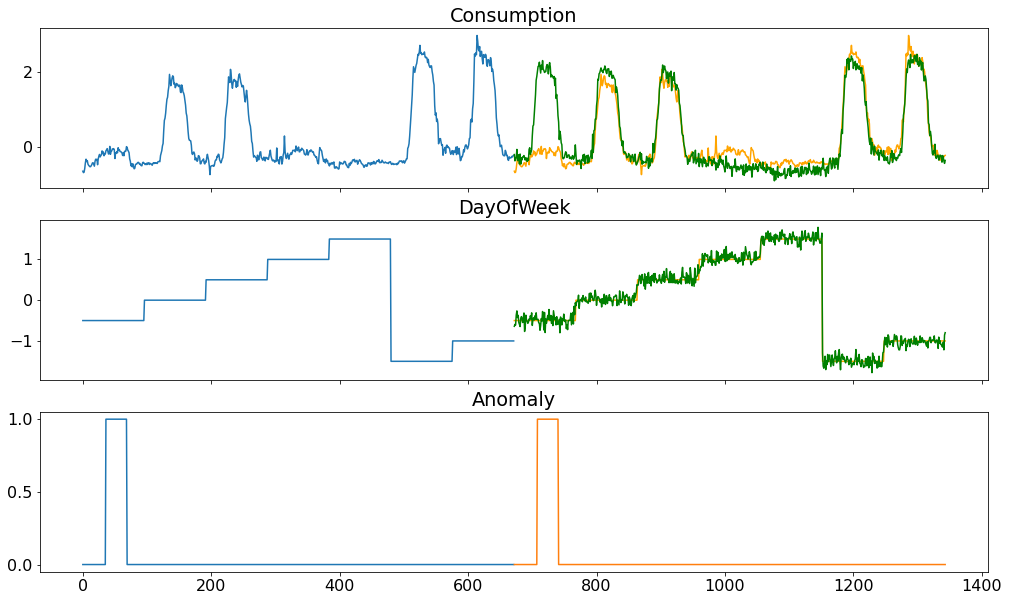

In [32]:
# Plotting predictions on the test set
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

## Computing reconstruction probability

In [33]:
# Function used to create non-overlapped windows starting from the TEST set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride
    print("PADDING: " +  str(padding_len))

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [34]:
test_weeks = [0,1,2,3,4,12,17,18,19,39,51] # Weeks that are in the test set
indexes = [0,5,6,9,10] # Considering positions in "text_weeks", indexes of weeks to be considered on alone (non consecutive)
full_seq_index = [] # Tells us which windows of X_Test_Overlapped have to be fully considered (for all the other windows we will consider last "stride" elements)

counter = 0 # Tells us which window of X_Test_Overlapped we're considering

X_test_overlapped = np.empty(shape=(0, 672, 2))

for i in range(len(indexes)): # For all windows to be considered on alone ...
    
    # Interval of consecutive weeks to be considered
    left = indexes[i]
    if i+1 < len(indexes):
        right = indexes[i+1]
    else:
        right = indexes[-1] + 1
    
    full_seq_index.append(counter)
    df = X_test_raw.iloc[(left)*672:(right)*672].copy()
    dataset = build_sequences_reconstruction(df, window, stride) # Creating sequences using consecutive weeks we have identified
    counter = counter + dataset.shape[0]
    X_test_overlapped = np.concatenate((X_test_overlapped, dataset[:,:,:2]), axis=0) # We concatenate new windows created
        
X_test_overlapped.shape, full_seq_index

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1013, 672, 2), [0, 673, 674, 1011, 1012])

In [35]:
reconstructed_prob = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
reconstructed_prob_written = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
new_start = 0
M = 50

for j in range (X_test_overlapped.shape[0]): # Consider all the windows in X_test_overlapped one at a time ...
    
    if(j%100==0): print(j)
    
    w = X_test_overlapped[j,:,:] 
    w = tf.expand_dims(w, 0)
    
    z_mean, z_log_var, z, c_mean, c_log_var, c = encoder(w) # Sampling only 1 time in the latent space
    
    if j in full_seq_index:
        
        for m in range(M):
            
            decoder_mu, decoder_log_sigma = decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            for i in range(window):  
                pdf_laplace = tfp.distributions.Laplace(decoder_mu[0, i, :-1], np.diag(decoder_sigma[0, i, :-1]), validate_args=True, name='Laplace')
                p_l = -(pdf_laplace.log_prob(X_test_overlapped[j, i, :-1]))
                reconstructed_prob[new_start+i] = reconstructed_prob[new_start+i] + p_l
                reconstructed_prob_written[new_start+i] = reconstructed_prob_written[new_start+i] + 1
                
        new_start = new_start+window
        
    else:
        
        for m in range(M):
            
            decoder_mu, decoder_log_sigma = decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            for i in range(stride):
                pdf_laplace = tfp.distributions.Laplace(decoder_mu[0, window-stride+i, :-1], np.diag(decoder_sigma[0, window-stride+i, :-1]), validate_args=True, name='Laplace')
                p_l = -(pdf_laplace.log_prob(X_test_overlapped[j, window-stride+i, :-1]))
                if new_start+i < X_test_raw.shape[0]: # To avoid problems related to padding
                    reconstructed_prob[new_start+i] = reconstructed_prob[new_start+i] + p_l
                    reconstructed_prob_written[new_start+i] = reconstructed_prob_written[new_start+i] + 1
                    
        new_start = new_start + stride
        
reconstructed_prob /= M
reconstructed_prob.shape, reconstructed_prob.max(), reconstructed_prob.min()

0
100
200
300
400
500
600
700
800
900
1000


((7392,), 3.3481388, 0.6932029)

In [36]:
reconstructed_prob_written.sum(), X_test_raw.shape[0]

(369600.0, 7392)

In [37]:
# Checking if we've written correct things inside "reconstruction_prob"
check = True
for i in range(reconstructed_prob_written.shape[0]):
    if reconstructed_prob_written[i] != M: # Each cell written M times
        check = False
        
print(check) # If true, everything okay

True


In [38]:
# Counting the number of elements in "reconstructed_prob" that are equal to 0
counter = 0
for i in range(reconstructed_prob.shape[0]):
    if reconstructed_prob[i] == 0:
        counter += 1
        
print(counter)

0


In [39]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_probabilities, threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=X_test_raw.shape[0])
    
    for i in range(reconstruction_probabilities.shape[0]): 
        if reconstruction_probabilities[i] > threshold:
            anomaly_predicted[i] = 1
            
    return anomaly_predicted

In [40]:
def select_best_threshold(reconstructed_prob, step, anomaly_true):
    
    min_prob = reconstructed_prob.min()
    max_prob = reconstructed_prob.max()
    max_F1 = 0
    best_threshold = 0
    counter = 0
    
    print("best threshold = " + str(best_threshold) + ", max F1 = " + str(max_F1))
    
    thresholds = [x for x in np.arange(min_prob, max_prob, step)]
    
    for threshold in thresholds:
        
        # print("Trying threshold: " + str(threshold))
        
        if(counter<50):
            
            anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)
            f1 = f1_score(y_true=anomaly_true, y_pred=anomaly_predicted)
            if f1 > max_F1:
                max_F1 = f1
                best_threshold = threshold
                print("best threshold =" + str(best_threshold) + ", max F1 = " + str(max_F1))
            else:
                counter = counter+1
        
        else:
            return best_threshold

In [41]:
step = 1/100
threshold = select_best_threshold(reconstructed_prob, step, Anomaly_Test)
anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)

threshold, anomaly_predicted.sum(), anomaly_predicted.shape

best threshold = 0, max F1 = 0
best threshold =0.6932029128074646, max F1 = 0.09559391909301726
best threshold =0.7032029128074646, max F1 = 0.09926421404682273
best threshold =0.7132029128074646, max F1 = 0.10296974743269499
best threshold =0.7232029128074646, max F1 = 0.10711707810018768
best threshold =0.7332029128074646, max F1 = 0.11126105862947969
best threshold =0.7432029128074646, max F1 = 0.11606444548725166
best threshold =0.7532029128074647, max F1 = 0.12122202254533573
best threshold =0.7632029128074647, max F1 = 0.12701129750085585
best threshold =0.7732029128074647, max F1 = 0.1330703012912482
best threshold =0.7832029128074647, max F1 = 0.13971003577480698
best threshold =0.7932029128074647, max F1 = 0.14640883977900554
best threshold =0.8032029128074647, max F1 = 0.15302124149309135
best threshold =0.8132029128074647, max F1 = 0.1606060606060606
best threshold =0.8232029128074647, max F1 = 0.16813958758214367
best threshold =0.8332029128074647, max F1 = 0.17545519035232

(1.6932029128074655, 392.0, (7392,))

In [42]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)
Anomaly_Test

,Anomaly
0,0
1,0
2,0
3,0
4,0
...,...
7387,0
7388,0
7389,0
7390,0


In [43]:
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted'] = anomaly_predicted 
X_test_raw['Reconstruction_Probability'] = reconstructed_prob
X_test_raw.head()

,Consumption,DayOfWeek,Anomaly_Label_GT,Anomaly_Predicted,Reconstruction_Probability
0,-0.660426,-0.499988,0,0.0,1.029980
1,-0.699319,-0.499988,0,0.0,1.052663
2,-0.685176,-0.499988,0,0.0,1.037102
3,-0.586177,-0.499988,0,0.0,0.928523
4,-0.434142,-0.499988,0,0.0,0.784409


In [44]:
X_test_raw['Anomaly_Label_GT']

0       0
1       0
2       0
3       0
4       0
       ..
7387    0
7388    0
7389    0
7390    0
7391    0
Name: Anomaly_Label_GT, Length: 7392, dtype: int64

In [45]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [46]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted, reconstruction_prob, columns): 
   
    figs, axs = plt.subplots(4, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:1]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange')  
        axs[i].set_title(col) 
                 
    axs[1].plot(np.arange(len(X[:,i])), a_true) 
    axs[1].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[1].set_title('Anomaly_Label_GT') 
    
    axs[2].plot(np.arange(len(X[:,i])), a_predicted) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted) 
    axs[2].set_title('Anomaly_Predicted')
    
    axs[3].plot(np.arange(len(X[:,i])), reconstruction_prob) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), reconstruction_prob) 
    axs[3].set_title('Reconstrution_Probability') 
    plt.show()

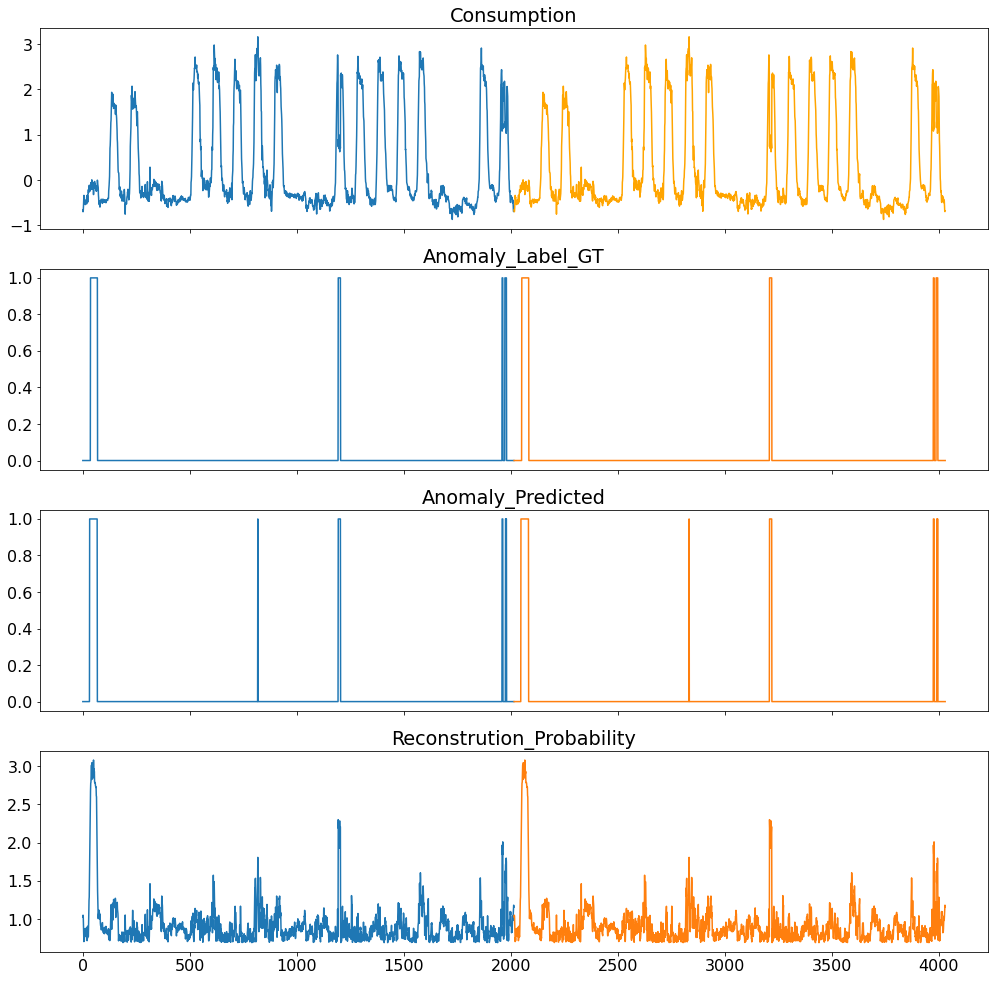

In [47]:
import datetime as dt

i=0
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

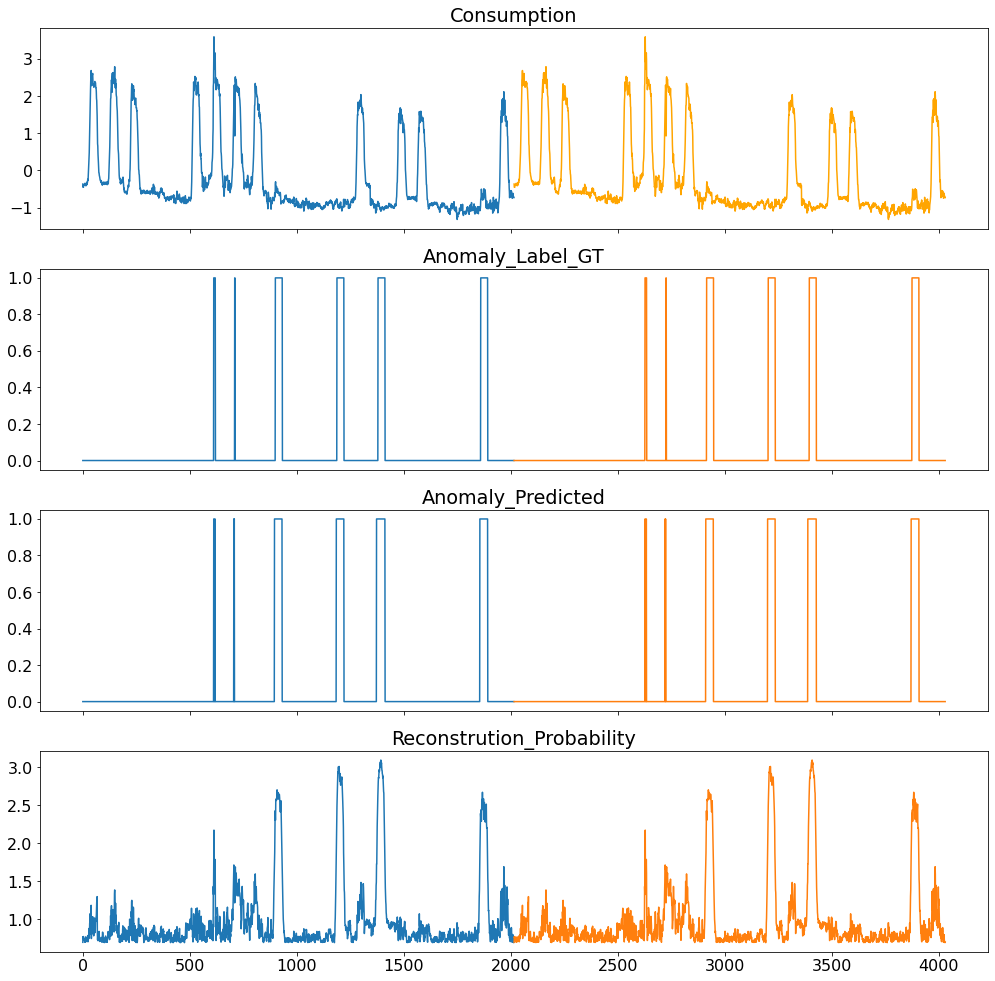

In [48]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

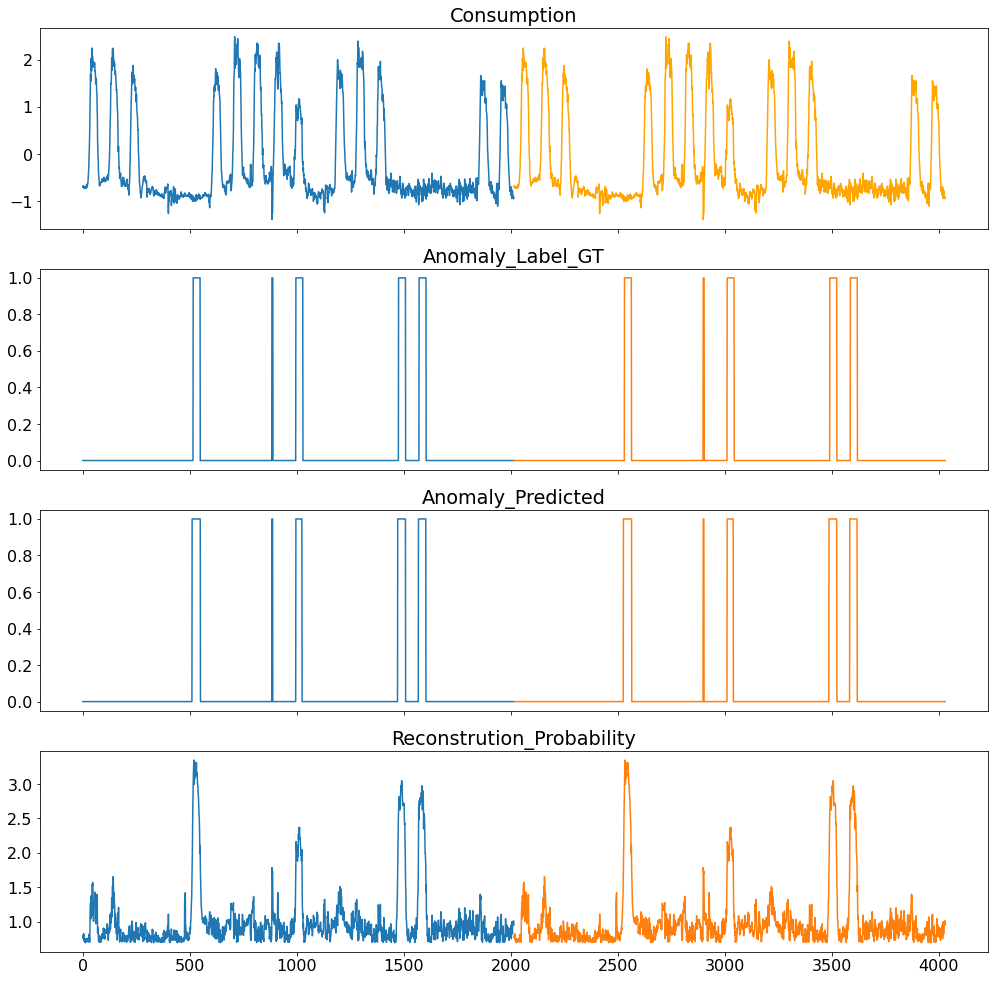

In [49]:
import datetime as dt

i=8
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels) 

Accuracy: 0.9912
Precision: 0.8903
Recall: 0.9407
F1: 0.9148


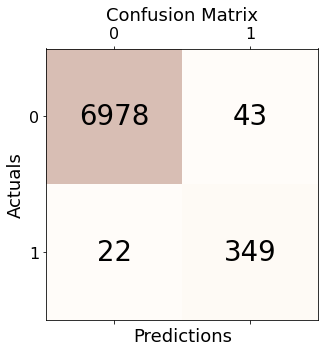

In [50]:
# anomaly_predicted = anomaly_predicted

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()